**Simple Lens Modeling 2**

Here we will see how to find uncertainties in the lens model parameters and convert those parameters into physical quantities.

First we will import some libraries, the lens models and the $\chi^2$ objects that were in the last tutorial.  They have been but into the two files ``lens_model.py`` and ``chi_squareds.py``.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=5) 
from scipy.optimize import minimize,fsolve,brentq

import astropy.cosmology as cosmo
# import the lens models from the last tutorial
from lens_models import *
# import the chi2 from the last tutorial
from chi_squareds import CHI_SQUARED_SOURCE,CHI_SQUARED_IMAGE

Now we will enter the data for HE0435-1223 again, create an SIE model and fit it to the data.  A combination of source plane opimization (SPO) and image plane optimization (IPO) seems to work best.  We use SPO to get a model with the right number of images and then switch to IPO to get the correct errors and perhaps a better model.  The best fit SPO model is used as an initialization for the IPO.    

SIE result for Q0435-1223 SIE
      fun: 0.0006170923001568289
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.30920666e-06,  3.17389342e-07, -1.01565891e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 64
      nit: 9
     njev: 16
   status: 0
  success: True
        x: array([1.22035667, 0.65752727, 0.24923571])


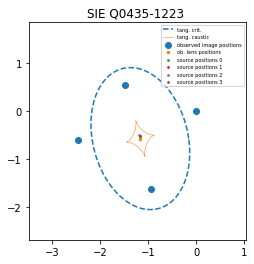

SIE result for Q0435-1223 SIE
      fun: 0.001777612233720761
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.90056913e-06, -3.05556360e-06, -5.95730063e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 32
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([1.21566718, 0.68419919, 0.24327551])


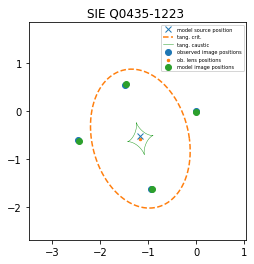

In [43]:
x_0435 =  np.array([[0,0],[-1.476,0.552],[-2.467,-0.603],[-0.939,-1.614]])
xo_0435 = np.array([-1.165,-0.573])

sie = sie_lens(xo_0435,1,0.999,0)
po =np.array([1.119,0.9,0])  

# create the chi2 object
chi2 = CHI_SQUARED_SOURCE(sie,x_0435)
result_sie = minimize(chi2,po,bounds=[[0,2],[0.2,0.99],[0,np.pi]])
# print the results
print("SIE result for Q0435-1223 SIE")
print(result_sie)
# make a plot
chi2.plot(result_sie,title='SIE Q0435-1223 ')

# create the chi2 object
chi2 = CHI_SQUARED_IMAGE(sie,x_0435)
po = result_sie.x
result_sie = minimize(chi2,po,bounds=[[0,2],[0.2,0.99],[0,np.pi]])
# print the results
print("SIE result for Q0435-1223 SIE")
print(result_sie)
# make a plot
chi2.plot(result_sie,title='SIE Q0435-1223 ')

Now we should have found a good model.  Now we need to find the errors on the parameters.

To do this we use the python package ```lmfit```. This package allows us to build complex fitting models for non-linear least-squares problems. The package documentation can be found at this [link](https://lmfit.github.io/lmfit-py/index.html).

We begin by setting up some initial guesses for the model parameters, storing them in a ``lmfit.Parameter`` object, including also some plausible ranges for the parameters.  There is also a boolian flag for each parameter which allows you to stop fitting a particular parameter.

In [44]:
import lmfit

degrees_to_rad = np.pi/180.

# initial guesses and ranges for parameters:
p = lmfit.Parameters()
p.add_many(('theta_e',result_sie.x[0],True,0,2)
           ,('fratio',result_sie.x[1],True, 0.2, 0.999)
           ,('p_angle',result_sie.x[2]/degrees_to_rad,True,0,180))
# For each parameter, we specify a initial value, a flag, two other values
# defining the search range. If the flag is True the parameter is free
# to vary, otherwise it is fixed to the initial value.

Now we need to a function to optimize which should be the IPO $\chi^2$, but one that accepts a ``lmfit.Parameters()`` object.  We also need the log of the likelihood which is closely related.

In [45]:
chi2 = CHI_SQUARED_IMAGE(sie,x_0435)
sigma = 0.05 ###  error in the position of the images in each dimension

# chi squared of cost function
def chi_squared(p):
    return chi2( [p['theta_e'],p['fratio'],p['p_angle']*degrees_to_rad] )

# log-likelihood function
def lnprob(p):
    lnp = -0.5 * chi_squared(p) /sigma/sigma
    lnp = lnp - len(xo_0435) * np.log(2 * np.pi * sigma**2)
    return lnp

Using ```lmfit``` we will find the best fit model again and at the same time create the ``minimize`` object which we need.

In [46]:
mi = lmfit.minimize(chi_squared, p, method='Nelder')
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)

[[Variables]]
    theta_e:  1.21566718 (init = 1.215667)
    fratio:   0.68419919 (init = 0.6841992)
    p_angle:  13.9386598 (init = 13.93866)


We should get back the same best-fit model or something close to it if everything is going well.

Now we are ready!  We will run the Monte Carlo Markov Chain (MCMC) using the ``'emcee'`` ``method``.  We use 100 independent chains (``nwalkers``) with a burn in period of 500 steps (``burn``).  We will let each chain go for 2000 steps (``steps``).

This might take a little while to run.

In [47]:

res = lmfit.minimize(lnprob, method='emcee',
                     nan_policy='omit', 
                     nwalkers=100, burn=500, steps=2000, 
                     params=mi.params,
                     progress=True)


100%|████████████████████████████████████████| 2000/2000 [05:17<00:00,  6.30it/s]


Now we will make a "corner" plot of the Monte Carlo chain estimate of the posterior for the lens parameters.  To run this you might have to install the ```corner``` plot package (```python -m pip install corner```).

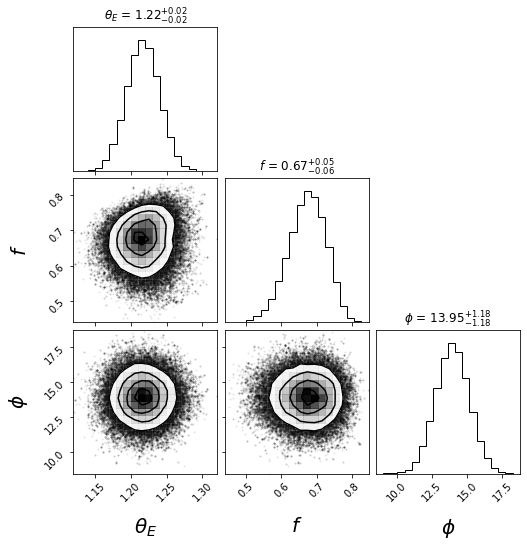

In [48]:
# show corner plot (confidence limits, parameter distributions, correlations)
import corner
labels=[r'$\theta_E$',r'$f$',r'$\phi$']
figure=corner.corner(res.flatchain, labels=labels, 
                     show_titles=True, title_kwargs={"fontsize": 12})

Calculate the physical size of the Einstein radius for HE0435-1223.  You can use the astropy.cosmology package to calculate the distances.  Calculate the critical density for this lens and mass within the Einstein radius.

In [59]:
# these might be useful
from astropy import constants as const 
from astropy import units as u
import astropy.cosmology as cosmo
def sc_note(n) :  ## this prints numbers in scientific notation
    return "{:e}".format(n)

cos = cosmo.FlatLambdaCDM(67.4,0.315)

zs = 1.689
zl = 0.45

Dl = cos.angular_diameter_distance_z1z2(0,zl)
Ds = cos.angular_diameter_distance_z1z2(0,zs)
Dls = cos.angular_diameter_distance_z1z2(zl,zs)

# Using result_sie, what is the Einstein radius in radians
theta_e = result_sie.x[0] * np.pi / 180 /60/60
print(" Einstein radius in radians = ",theta_e)

# Einstein radius in kpc
Re = theta_e * Dl *( 1000*u.kpc/u.Mpc )
print(" Einstein radius = ",Re)

# Critical density in Msolar / kpc**2

Sigma_crit = const.c**2 / 4 /np.pi/const.G * Ds/Dl/Dls
print(Sigma_crit)
Sigma_crit = Sigma_crit * ( u.m*u.Mpc.to('m')/u.Mpc )
print(Sigma_crit)
Sigma_crit = Sigma_crit * ( u.M_sun/u.M_sun.to('kg')/u.kg )
print(Sigma_crit)
Sigma_crit = Sigma_crit * ( u.Mpc/1000/u.kpc)**2
print(sc_note(Sigma_crit))

# mass within the Einstein radius
M = Sigma_crit * np.pi * Re**2

print('Einstein mass : ',sc_note(M))

 Einstein radius in radians  5.89372080481809e-06
 Einstein radius  7.237497093137891 kpc
1.3837934995270809e+23 kg / (m Mpc)
4.269940578904198e+45 kg / Mpc2
2147414696450482.2 solMass / Mpc2
2.147415e+09 solMass / kpc2
Einstein mass :  3.533805e+11 solMass
